In [1]:
import rasa_core
from rasa_core.agent import Agent
from bokeh.io import output_notebook
agent = Agent.load("models/dialogue_embed")
# agent = Agent.load("models/dialogue_embed_before_norm_loss")
output_notebook()

/usr/local/lib/python3.6/site-packages/pykwalify/core.py:99: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  data = yaml.load(stream)


INFO:tensorflow:Restoring parameters from models/dialogue_embed/policy_0_EmbeddingPolicy/tensorflow_embedding.ckpt


Loading BokehJS ...

In [2]:
rasa_core.__version__

'0.11.0a1'

In [3]:
policy = agent.policy_ensemble.policies[0]
interpreter = agent.interpreter

In [4]:
domain = agent.domain


In [5]:
from rasa_core.training.structures import StoryGraph
from rasa_core.training.dsl import StoryFileReader
from rasa_core.trackers import DialogueStateTracker
from rasa_core.channels import UserMessage
import numpy as np
np.set_printoptions(precision=3, suppress=True)

def embedding_from_tracker(story, bot=False, predict_only=False):
    reader = StoryFileReader(domain, interpreter)
    story = story.split('\n')
    story_steps = reader.process_lines(story)
#     story_graph = StoryGraph(story_steps)
    tracker = DialogueStateTracker(
            1,
            domain.slots
    )
    tracker._reset()
    for step in story_steps:
        events = step.explicit_events(domain)
        for event in events[:-1]:
            tracker.update(event)

    if predict_only:
        return policy.predict_action_probabilities(tracker, domain)

    data_X = policy.featurizer.create_X([tracker], domain)
    session_data = policy._create_tf_session_data(domain, data_X)
    all_Y_d_x = np.stack([session_data.all_Y_d for _ in range(session_data.X.shape[0])])
    feed_dict={policy.a_in: session_data.X,
               policy.b_in: all_Y_d_x,
               policy.c_in: session_data.slots,
               policy.b_prev_in: session_data.previous_actions,
               policy._dialogue_len: session_data.X.shape[1],
               policy._x_for_no_intent_in: session_data.x_for_no_intent,
               policy._y_for_no_action_in: session_data.y_for_no_action,
               policy._y_for_action_listen_in: session_data.y_for_action_listen}

    dial_vec = policy.session.run(policy.dial_embed, feed_dict=feed_dict)
    bot_vec = policy.session.run(policy.bot_embed, feed_dict=feed_dict)

    no_skip_gate = policy.session.run(policy.copy_attn_debug, feed_dict=feed_dict)
    attn_embed = policy.session.run(policy.attn_embed, feed_dict=feed_dict)
    rnn_embed = policy.session.run(policy.rnn_embed, feed_dict=feed_dict)
    probs = policy.session.run(policy.alignment_history, feed_dict=feed_dict)
    sims = policy.session.run(policy.sim_op, feed_dict=feed_dict)
    if bot is False:
        sims1 = policy.predict_action_probabilities(tracker, domain)

    del tracker
#     print(np.shape(dial_vec))

    if bot is False:
        return (dial_vec[0,-1,:],
                no_skip_gate[0,-1,:],
                attn_embed[0,-1,:],
                rnn_embed[0,-1,:],
                probs[0,-1,:],
                sims[0,-1,:],
                sims1)
    else:
        return (dial_vec[0,-1,:],
                sims[0,-1,:],
                bot_vec[0,-1,:,:])
    
def make_prediction(story):
    dial, sim0, bot = embedding_from_tracker(story, bot=True)
    abs_vals = np.array([np.absolute(vec) for vec in bot])
    norms = np.apply_along_axis(np.linalg.norm, 1, bot)
    sims = np.dot(bot, dial)/norms
#     name = domain.action_for_index(np.argmax(sims)).name()
#     print(name)
    name = domain.action_names[np.argmax(sim0)]
#     print(name)
#     print('---')
#     ids = sim0.argsort()[::-1]
#     print(ids)
#     print(sims[ids])
    return '- ' + name, np.max(sim0)
#     print(dial.shape, bot.shape)

In [6]:
# print(domain.intents)
story_block = """* request_hotel
    - utter_ask_details
* explain
    - utter_explain_details_hotel
    - utter_ask_details
* chitchat
    - utter_chitchat
    - utter_ask_details
* inform{"enddate": "May 26th"}
    - slot{"enddate": "May 26th"}
    - utter_ask_startdate
* inform{"startdate": "next week"}
    - slot{"startdate": "next week"}
    - utter_ask_location
* correct{"startdate": "next week"}
    - slot{"startdate": "next week"}
    - utter_correct_startdate_hotel
    - utter_ask_location
* explain
    - utter_explain_location_hotel
    - utter_ask_location
* inform{"location": "rome"}
    - slot{"location": "rome"}
    - utter_ask_price
* chitchat
    - utter_chitchat
    - utter_ask_price
* chitchat
    - utter_chitchat
    - utter_ask_price
* chitchat
    - utter_chitchat
    - utter_ask_price
* chitchat
    - utter_chitchat
    - utter_ask_price
* explain
    - utter_explain_price_hotel
    - utter_ask_price
* inform{"price": "expensive"}
    - utter_ask_people
* inform{"people": "4"}
    - utter_filled_slots
    - utter_search_hotel
    - slot{"hotel": "hotel"}
    - utter_suggest_hotel
* chitchat
    - utter_chitchat
    - utter_suggest_hotel
* affirm
    - utter_happy"""

In [12]:
story_block = """* request_hotel
    - utter_ask_details
* inform{"people": "4"}
    - slot{"people": "4"}
    - utter_ask_location
* correct{"people": "2"}
    - slot{"people": "2"}
    - utter_correct_people_hotel
    - utter_ask_location
* chitchat
    - utter_chitchat
    - utter_ask_location
* inform{"location": "rome"}
    - slot{"location": "rome"}
    - utter_ask_price
* inform{"price": "expensive"}
    - slot{"price": "expensive"}
    - utter_ask_startdate
* inform{"startdate": "next week", "enddate": "tomorrow"}
    - slot{"startdate": "next week"}
    - slot{"enddate": "tomorrow"}
    - utter_filled_slots
    - utter_search_hotel
    - slot{"hotel": "hotel"}
    - utter_suggest_hotel
* correct{"enddate": "May 26th"}
    - slot{"enddate": "May 26th"}
    - utter_correct_enddate_hotel
    - utter_search_hotel
    - slot{"hotel": "hotel"}
    - utter_suggest_hotel
* correct{"location": "rome"}
    - slot{"location": "rome"}
    - utter_correct_location_hotel
    - utter_search_hotel
    - slot{"hotel": "hotel"}
    - utter_suggest_hotel
* did_that_work
    - utter_worked_hotel
    - utter_suggest_hotel
* affirm
    - utter_happy
* chitchat"""

In [13]:
# story_block = """* request_hotel
#     - utter_ask_details
# * inform{"people": "2"}
#     - slot{"people": "2"}
#     - utter_ask_location
# * did_that_work
#     - utter_more_info_hotel
#     - utter_ask_location
# * chitchat
#     - utter_chitchat
#     - utter_ask_location
# * did_that_work
#     - utter_more_info_hotel
#     - utter_ask_location
# * inform{"location": "paris"}
#     - utter_ask_price
# * inform{"price": "expensive"}
#     - utter_ask_startdate
# * inform{"startdate": "10.03.2018"}
#     - utter_ask_enddate
# * explain
#     - utter_explain_enddate_hotel
#     - utter_ask_enddate
# * chitchat
#     - utter_chitchat
#     - utter_ask_enddate
# * explain
#     - utter_explain_enddate_hotel
#     - utter_ask_enddate
# * inform{"enddate": "10.03.2018"}
#     - utter_filled_slots
#     - action_search_hotel
#     - slot{"hotel": "hotel"}
#     - utter_suggest_hotel
# * affirm
#     - utter_happy
# """

In [14]:
print(len(story_block.split('\n')))
cool_list = []
lines = story_block.split('\n')
for idx, line in enumerate(lines):
    if idx == len(lines)-1:
        continue
#     if '*' in lines[idx+1] or 'slot{' in lines[idx+1]:
    if 'slot{' in lines[idx+1]:
        continue
    sub_story = '\n'.join(lines[:idx+1])
    (dial, not_skip, attn, rnn, probs, sims, sims1
    ) = embedding_from_tracker("#generate story\n{}".format(sub_story))
#     print(np.max(sims), np.max(sims1))
    pred, sim = make_prediction("#generate story\n{}".format(sub_story))
    cool_list.append((lines[idx+1].strip(), dial, (pred, sim, sims), not_skip, attn[-20:], rnn,
                      probs[:20], probs[-20:]))
#     embedding_from_tracker("#generate story\n{}".format(sub_story), predict_only=True)

print(len(cool_list))
print(cool_list[0][4].shape)
#     break
# dial = embedding_from_tracker("#generate story\n{}".format(story_block)
# )
# print(dial.shape)
# print(len(story_block.split('\n')))

43
31
(20,)


In [15]:
import copy

# cool_list0 = copy.deepcopy(cool_list)
# cool_list[27]

In [18]:
# cool_list1= copy.deepcopy(cool_list)
cool_list[-1]

('* chitchat',
 array([ 0.101,  0.162, -0.012, -0.195, -0.066, -0.145, -0.014, -0.099,
         0.073, -0.603, -0.095, -0.154,  0.09 ,  0.19 ,  0.068, -0.269,
         0.345,  0.265,  0.379, -0.062], dtype=float32),
 ('- action_listen',
  0.96368885,
  array([ 0.964,  0.034, -0.104, -0.008, -0.071, -0.002, -0.076,  0.03 ,
         -0.062, -0.054, -0.241, -0.059, -0.083,  0.009, -0.032, -0.033,
         -0.011,  0.012, -0.004, -0.015, -0.022, -0.016, -0.023,  0.025,
         -0.005, -0.001, -0.021, -0.105, -0.117, -0.183, -0.001, -0.015,
         -0.014, -0.036, -0.036, -0.034, -0.035,  0.015, -0.03 , -0.211,
         -0.117, -0.045, -0.088], dtype=float32)),
 array([1., 1., 1., 1., 1.], dtype=float32),
 array([ 0.004,  0.042,  0.065,  0.071, -0.038, -0.012, -0.01 , -0.038,
        -0.059,  0.019, -0.04 , -0.009, -0.04 ,  0.013, -0.01 , -0.021,
         0.001, -0.067,  0.017,  0.033], dtype=float32),
 array([ 0.097,  0.12 , -0.077, -0.266, -0.028, -0.133, -0.005, -0.061,
         0.132,

In [12]:
import matplotlib.pyplot as plt
plt.plot(cool_list[15][-2], marker='x')

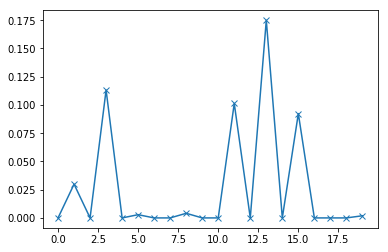

In [13]:
plt.plot(cool_list[19][-2], marker='x')

In [14]:
from sklearn.decomposition import PCA

In [15]:
pca = PCA(n_components=2)
X = pca.fit_transform([ting[1] for ting in cool_list])

In [16]:
from bokeh.plotting import figure, show
import matplotlib.pyplot as plt

In [17]:
embed_dim = cool_list[0][1].shape[0]


In [18]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, Arrow, OpenHead

hover = HoverTool(tooltips=[("true action","@desc"), ("prediction", "@pred"),
                            ("not_skip_gate", "@not_skip")],names=['circle'])
p = figure( tools=[hover])

for i in range(1, len(X)):
    p.add_layout(Arrow(end=OpenHead(line_color="firebrick", size=10, line_width=2),
                       x_start=X[i-1,0], y_start=X[i-1,1],
                       x_end=X[i,0], y_end=X[i,1], line_color='gray'))

source = ColumnDataSource(data=dict(
    x=X[:,0],
    y=X[:,1],
    desc=[ting[0] for ting in cool_list],
    pred = [ting[2][0] for ting in cool_list],
    not_skip = [ting[3][-1] for ting in cool_list]
))
p.circle('x','y', source=source, size=10, name='circle')
# p.line(X[:,0], X[:,1])

X1 = pca.transform([ting[4] for ting in cool_list])
source = ColumnDataSource(data=dict(
    x=X1[:,0],
    y=X1[:,1],
    desc=[ting[0] for ting in cool_list],
    pred = [ting[2][0] for ting in cool_list],
    not_skip = [ting[3][-1] for ting in cool_list]
))
p.circle('x','y', source=source, size=5, color='green', name='circle')

X2 = pca.transform([ting[5] for ting in cool_list])
source = ColumnDataSource(data=dict(
    x=X2[:,0],
    y=X2[:,1],
    desc=[ting[0] for ting in cool_list],
    pred = [ting[2][0] for ting in cool_list],
    not_skip = [ting[3][-1] for ting in cool_list]
))
p.circle('x','y', source=source, size=5, color='red', name='circle')

x = pca.transform(np.zeros((1,embed_dim)))
p.circle(x[0,0], x[0,1], size=5, color='magenta')
p.circle(X[0,0], X[0,1], size=10, color='green')
p.circle(X[-1,0], X[-1,1], size=10, color='red')


bokeh.models.renderers.GlyphRenderer(
    id='a5c0065e-b0d8-48c0-a9b7-e318dfd0ed24',
    data_source=bokeh.models.sources.ColumnDataSource(
        id='b26a7c64-0407-4318-be2e-91d43b436846',
        callback=None,
        data={},
        js_event_callbacks={},
        js_property_callbacks={},
        name=None,
        selected=bokeh.models.selections.Selection(
            id='0e3124b5-0e50-4d32-be24-6b5e4f41be31',
            indices=[],
            js_event_callbacks={},
            js_property_callbacks={},
            line_indices=[],
            multiline_indices={},
            name=None,
            subscribed_events=[],
            tags=[]),
        selection_policy=bokeh.models.selections.UnionRenderers(
            id='69a24e6a-6030-4396-bbdc-5e68148bcb0e',
            js_event_callbacks={},
            js_property_callbacks={},
            name=None,
            subscribed_events=[],
            tags=[]),
        subscribed_events=[],
        tags=[]),
    glyph=bokeh.models.markers.Circle(
        id='c6fa576b-1167-403f-81e3-c2db4e6d6b07',
        angle={'value': 0.0, 'units': 'rad'},
        fill_alpha={'value': 1.0},
        fill_color={'value': 'red'},
        js_event_callbacks={},
        js_property_callbacks={},
        line_alpha={'value': 1.0},
        line_cap='butt',
        line_color={'value': 'red'},
        line_dash=[],
        line_dash_offset=0,
        line_join='bevel',
        line_width={'value': 1},
        name=None,
        radius=None,
        radius_dimension='x',
        size={'value': 10, 'units': 'screen'},
        subscribed_events=[],
        tags=[],
        x={'value': -0.1753314113833793},
        y={'value': 0.20870170072310434}),
    hover_glyph=None,
    js_event_callbacks={},
    js_property_callbacks={},
    level='glyph',
    muted=False,
    muted_glyph=None,
    name=None,
    nonselection_glyph=bokeh.models.markers.Circle(
        id='e5ed9074-e862-4991-82f4-8be865b859c7',
        angle={'value': 0.0, 'units': 'rad'},
        fill_alpha={'value': 0.1},
        fill_color={'value': '#1f77b4'},
        js_event_callbacks={},
        js_property_callbacks={},
        line_alpha={'value': 0.1},
        line_cap='butt',
        line_color={'value': '#1f77b4'},
        line_dash=[],
        line_dash_offset=0,
        line_join='bevel',
        line_width={'value': 1},
        name=None,
        radius=None,
        radius_dimension='x',
        size={'value': 10, 'units': 'screen'},
        subscribed_events=[],
        tags=[],
        x={'value': -0.1753314113833793},
        y={'value': 0.20870170072310434}),
    selection_glyph=None,
    subscribed_events=[],
    tags=[],
    view=bokeh.models.sources.CDSView(
        id='0fb8e34a-64e0-44d2-b0fa-22dc80500982',
        filters=[],
        js_event_callbacks={},
        js_property_callbacks={},
        name=None,
        source=bokeh.models.sources.ColumnDataSource(
            id='b26a7c64-0407-4318-be2e-91d43b436846',
            callback=None,
            data={},
            js_event_callbacks={},
            js_property_callbacks={},
            name=None,
            selected=bokeh.models.selections.Selection(
                id='0e3124b5-0e50-4d32-be24-6b5e4f41be31',
                indices=[],
                js_event_callbacks={},
                js_property_callbacks={},
                line_indices=[],
                multiline_indices={},
                name=None,
                subscribed_events=[],
                tags=[]),
            selection_policy=bokeh.models.selections.UnionRenderers(
                id='69a24e6a-6030-4396-bbdc-5e68148bcb0e',
                js_event_callbacks={},
                js_property_callbacks={},
                name=None,
                subscribed_events=[],
                tags=[]),
            subscribed_events=[],
            tags=[]),
        subscribed_events=[],
        tags=[]),
    visible=True,
    x_range_name='default',
    y_range_name='default')

In [19]:
show(p)

In [18]:
print('utter_ask_price', '-->', domain.index_for_action('utter_ask_price'))
print('utter_ask_details', '-->', domain.index_for_action('utter_ask_details'))
print('utter_ask_people', '-->', domain.index_for_action('utter_ask_people'))
print('utter_explain_details_hotel', '-->', domain.index_for_action('utter_explain_details_hotel'))
print('utter_explain_people_hotel', '-->', domain.index_for_action('utter_explain_people_hotel'))
print('utter_explain_price_hotel', '-->', domain.index_for_action('utter_explain_price_hotel'))
print('utter_ask_location', '-->', domain.index_for_action('utter_ask_location'))
print('utter_explain_location_hotel', '-->', domain.index_for_action('utter_explain_location_hotel'))
print('utter_ask_startdate', '-->', domain.index_for_action('utter_ask_startdate'))
print('utter_suggest_hotel', '-->', domain.index_for_action('utter_suggest_hotel'))
print('action_search_hotel', '-->', domain.index_for_action('action_search_hotel'))
print('action_listen', '-->', domain.index_for_action('action_listen'))

utter_ask_price --> 6
utter_ask_details --> 28
utter_ask_people --> 4
utter_explain_details_hotel --> 14
utter_explain_people_hotel --> 19
utter_explain_price_hotel --> 21
utter_ask_location --> 5
utter_explain_location_hotel --> 17
utter_ask_startdate --> 7
utter_suggest_hotel --> 12
action_search_hotel --> 42
action_listen --> 0


In [19]:
utter_price = embedding_from_tracker("#generate story\n{}".format(story_block), bot=True)[0,-1,5,:]
utter_price.shape

(20,)

In [20]:
print(utter_price.shape)
x = pca.transform(utter_price.reshape(1,-1))
p.circle(x[0][0], x[0][1], color='black')

(20,)


GlyphRenderer(id='1db745d9-cfee-44a7-8a51-a238a358f252', ...)

In [21]:
show(p)

In [22]:
from collections import namedtuple

In [23]:
Point = namedtuple('Point', ['x', 'y'])
p = Point(11, y=22)
p._asdict()

OrderedDict([('x', 11), ('y', 22)])

In [24]:
Point3D = namedtuple('Point3D', Point._fields + ('z',))

In [25]:
p_asdict = p._asdict()
p_asdict['z'] = 3
p_asdict

OrderedDict([('x', 11), ('y', 22), ('z', 3)])

In [26]:
p3D = Point3D(**p_asdict)
p3D

Point3D(x=11, y=22, z=3)

In [27]:
x ={
        "day": "20",
        "month": "06",
        "year": "2018"
    }

In [28]:
x

{'day': '20', 'month': '06', 'year': '2018'}

In [29]:
def value_touched_dict(value):
    if isinstance(value, dict) and value.get("day"):
        value["value1"] = value.pop("day")
        value["value2"] = value.pop("month")
        value["value3"] = value.pop("year")
    return {"value": value,
            "touched": True}
value_touched_dict(x)

{'touched': True, 'value': {'value1': '20', 'value2': '06', 'value3': '2018'}}

In [30]:
value_touched_dict('x')

{'touched': True, 'value': 'x'}